Hunter Bennett | Glass Lab | Kupffer Strains Project | June 17 2021

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Differential scatter plot similar to those make in Link et al. 2018 showing differential peaks at fc > 2 and fc > 4.

In [9]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import import_homer_diffgene

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [11]:
dataDirectory = '../A00_Strains_Control_WholeLiver_RNA/'
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [12]:
if not os.path.isdir('./fancy_figures/'):
    os.mkdir('./fancy_figures/')

### Import differential peaks

In [13]:
diff, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
    '../A00_Strains_Control_WholeLiver_RNA/differential/aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt',
    '../A00_Strains_Control_WholeLiver_RNA/expression/HOMER.rawTPM.txt')

ge all transcripts (24940, 43)
Diff Gene selected transcripts (5501, 14)
ge selected transcripts (5501, 43)


In [14]:
def pca_rpkm_mat(rpkm, group_labels, n_pca=10, plot_size=8, legend=True):
    '''This function takes a pandas DF of rpkm values (genes x samples) with
    genes as the index and sample names as the column names and runs a simple
    PCA analysis.
    Accepts: 
    rpkm: gene x n_sample matrix of rpkm values
    group_labels: n_sample length array of group labels
    n_pca: number of principal components to analyze
    legend (bool): whether to plot legend
    Returns:
    tpm_pca_df: dataframe of principal components per each sample
    exp_var: array of explained variances for each PC
    
    TO DO:
    - change to matplotlib based scatter and return two subplots
    PC1 vs PC2 and PC2 vs PC3'''
    
    # import packages
    import pandas as pd
    import numpy as np
    import seaborn as sns
    # Import packages for PCA analysis
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA # uses SVD
    
    # scale data
    tpm_std = StandardScaler().fit_transform(rpkm)
    # run PCA
    pca = PCA(n_components=n_pca)
    tpm_pca = pca.fit_transform(tpm_std.T)
    exp_var = pca.explained_variance_ratio_
    
    #create df for plotting
    tpm_pca_df = pd.DataFrame(tpm_pca,
                              columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)],
                              index=(group_labels))
    tpm_pca_df.index.rename('group', inplace=True)
    tpm_pca_df.reset_index(inplace=True)
    
    ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                height=plot_size, scatter_kws={'s': 150},
                legend=legend)
    ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
    
    # return weights of each gene  
    transcript_pc = pd.DataFrame(pca.components_.T,
                                 rpkm.index,
                                 columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)])    

    return tpm_pca_df, exp_var, transcript_pc



# Make PCA Plot

In [15]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(tpm_mat.columns.str.split('/').str[-1])
strain = samples.str.split('_').str[0]
cell = []
for celltype in ['Kupffer', 'Hepatocyte', 'LSEC', 'Stellate']:
    for samp in samples.tolist():
        if celltype in samp:
            cell.append(celltype)

samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(strain),
                          pd.Series(cell)],
                         index=['sampleID', 
                                'strain',
                                'cell']).T

Run PCA Analysis

In [16]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# scale data
tpm_std = StandardScaler().fit_transform(tpm_mat)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_

#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca,
                          columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)],
                          index=(samplesDF.strain+'_'+samplesDF.cell))
tpm_pca_df.index.rename('group', inplace=True)
tpm_pca_df.reset_index(inplace=True)

Prep plotting stuff

In [17]:

cell_types = ['AJ_Hepatocyte'
                     'BALB_Hepatocyte'
                     'C57_Hepatocyte'
                     'AJ_Kupffer'
                     'BALBC_Kupffer'
                     'C57B6J_Kupffer'
                     'AJ_LSEC'
                     'BALBC_LSEC'
                     'C57B6J_LSEC'
                     'AJ_Stellate'
                     'BALBC_Stellate'
                     'C57B6J_Stellate']

In [18]:
strain_color_dict = {'AJ_Hepatocyte':'#fe9929',
                     'BALB_Hepatocyte':'#d95f0e',
                     'C57_Hepatocyte':'#d95f0e',
                     'AJ_Kupffer':'#74c476',
                     'BALBC_Kupffer':'#31a354',
                     'C57B6J_Kupffer':'#006d2c',
                     'AJ_LSEC':'#fb6a4a',
                     'BALBC_LSEC':'#de2d26',
                     'C57B6J_LSEC':'#a50f15',
                     'AJ_Stellate':'#9e9ac8',
                     'BALBC_Stellate':'#756bb1',
                     'C57B6J_Stellate':'#54278f'}

cell_types = ['AJ_Hepatocyte',
                     'BALB_Hepatocyte',
                     'C57_Hepatocyte',
                     'AJ_Kupffer',
                     'BALBC_Kupffer',
                     'C57B6J_Kupffer',
                     'AJ_LSEC',
                     'BALBC_LSEC',
                     'C57B6J_LSEC',
                     'AJ_Stellate',
                     'BALBC_Stellate',
                     'C57B6J_Stellate']

from matplotlib.patches import Patch

legend_elements = []
for lab, in  zip(cell_types):
    legend_elements.append(Patch(label=lab, color=strain_color_dict[lab]))

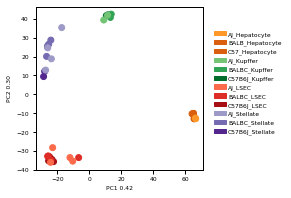

In [19]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(tpm_pca_df.PC1,
           tpm_pca_df.PC2,
           c=[strain_color_dict[i] for i in tpm_pca_df.group])

ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
ax.legend(handles=legend_elements, fontsize=6,markerscale=1, frameon=False, ncol=1, loc=[1.05,0.2],
          handletextpad=0.3, columnspacing=0.1)

plt.savefig('./fancy_figures/hepatic_facs_rna_pca.pdf',
            bbox_inches='tight')

# Correlation plot

In [26]:
tpm_mat.columns = samplesDF.strain+'_'+samplesDF.cell

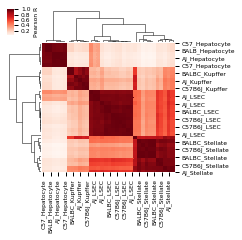

In [33]:
sns.clustermap(tpm_mat.corr(),
               cmap='Reds',
               figsize=(3,3),
               cbar_kws={'label':'Pearson R'})
plt.savefig('./fancy_figures/hepatic_facs_rna_corr.pdf',
            bbox_inches='tight')